In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals

%matplotlib inline
import sys
sys.path.insert(0,r"C:\Users\nanw0\GoogleDrive\SLAC\SLAC-Diling\8. 20 Winter\Beam_propagation\WPG\WPG-develop")

%load_ext autoreload

#Importing necessary modules:
import os, copy, time

sys.path.insert(0,os.path.join('..','..'))
#sys.path.insert('../..')

import numpy as np
import pylab as plt

# import auxiliar functions
%autoreload 2
from Auxiliary import *

In [2]:
''' crystal variables  '''
crystal_type='220'
ang_as = np.deg2rad(2)           # asymmetric angle

if crystal_type == '111':
    ''' Silicon 111 crystal '''
    d_sp = 3.13557135638         # reflecting plane d-spacing [A]
    psi0r = -9.964087683e-6      # real part of 0th Fourier component of crystal polarizability
    psi0i = 1.554410972e-7       # imaginary part of ""
    psi_hr = -5.264819463e-6     # real part of Hth Fourier component
    psi_hi = 1.085248779e-7      # imaginary part of ""
    psi_hbr = -5.264819463e-6    # real part of -Hth Fourier coumponent
    psi_hbi = 1.085248779e-7     # imaginary part of ""
    
if crystal_type == '220':
    ''' Silicon 220 crystal '''
    d_sp = 1.9201374688016222    # reflecting plane d-spacing [A]
    psi0r = -9.964087683e-6      # real part of 0th Fourier component of crystal polarizability
    psi0i = 1.554410972e-7       # imaginary part of ""
    psi_hr = -6.054689535e-6     # real part of Hth Fourier component
    psi_hi = 1.502594247e-7      # imaginary part of ""
    psi_hbr = -6.054689535e-6    # real part of -Hth Fourier coumponent
    psi_hbi = 1.502594247e-7     # imaginary part of ""
    

    
tc = 150e-6                       # crystal thickness
uc = 1                            # use case: 1 (Bragg reflection); 2 (Bragg transmission)
ang_dif_pl = np.pi/2                 # diffraction plane angle: 0 (vertical); pi/2 (horizontal)
Temp_Crystal = SRWLOptCryst(d_sp,psi0r,psi0i,psi_hr,psi_hi,psi_hbr,psi_hbi,tc,ang_as,_uc=uc)

''' incident beam variables '''
ekev = 9.9                  # photon energy [kev]
pulse_duration = 3e-15      # pulse duration (rms) [s]
z1 = 400                    # distance to first OE [m]
sigX = 50e-6/(2*np.sqrt(2*np.log(2)))  # w0 (rms) [m]

if_load_input = 0           # load (1) or generate (0) incident wavefront

# default values
qnC = 0.1                   # charge [nC]
pulseEnergy = 0.5e-3        # pulse energy [J]
hbar = 0.6582119569         # eV * fs


# Calculate sampling paremeters

In [3]:
''' sampling parameters '''
npoints = 256         # wavefront sampling dimension
npointsx = npoints    # number of points vs horizontal position
npointsy = npoints    # """"""""""""""""""  vertical position

range_xy = 5000e-6    # spatial sampling range
trange = 2000e-15     # time window

''' calculations '''
bw = 2 * np.sqrt(2) * hbar * np.sqrt(np.log(2)) / (pulse_duration*1e15)
E_range = 6 * bw
f_range = E_range/4.136
nz = int(trange*1e15*f_range)+1
if nz % 2!=0:
    nz += 1
dt = trange/nz
dev = E_range/nz
pulseRange = np.round(trange/pulse_duration)+1

print('sampling parameters:\n    {}fs dt, {}meV deV, {} nz, {} pulseRange'.format(
    round(dt*1e15,2), round(dev*1e3,2), nz, round(pulseRange,2)))

sampling parameters:
    1.33fs dt, 2.07meV deV, 1500 nz, 668.0 pulseRange


In [4]:
''' directories '''
# output data directory
strDataFolderName = 'WPG_output/' 
mkdir(strDataFolderName)

# sub-folder for current sampling condition
dirname_case = strDataFolderName+'ray_tracing/'
mkdir(dirname_case)
    
# sub-sub-folder for current sampling parameters
dirname_duration = dirname_case+'{} fs/'.format(
    round(pulse_duration*1e15,1))
mkdir(dirname_duration)

# incident beam
dirname_input = dirname_duration+'incident_beam/'
mkdir(dirname_input)

# propagated beam, mono
dirname_mono = dirname_duration+'mono/'
mkdir(dirname_mono)


path exists
path exists
path exists
path exists
path exists


In [5]:
name0 = 'input'
fname_incident = dirname_input + 'wf_{}.h5'.format(name0)

''' load or generate '''
tstart = time.time()
if if_load_input ==1:
    print('loading incident wavefront')
    mwf = Wavefront()
    try:
        mwf.load_hdf5(fname_incident)
    except:
        if_load_input = 0
        print("incident wavefront doesn't exist")

if if_load_input != 1:
    print('generating incident wavefront')
    wfr0 = build_gauss_wavefront(npointsx, npointsy, nz, ekev, -range_xy/2, range_xy/2,
                                    -range_xy/2, range_xy/2 ,pulse_duration, sigX, sigX, z1,
                                    pulseEn=pulseEnergy,pulseRange=pulseRange)

    mwf = Wavefront(wfr0)
    srwl.SetRepresElecField(mwf._srwl_wf, 'f')
    print('saving incident wavefront'.format(round(time.time()-tstart,2)))
    mwf.store_hdf5(fname_incident)
print('finished in {}s'.format(round(time.time()-tstart,2)))


generating incident wavefront
saving incident wavefront
finished in 51.18s


done


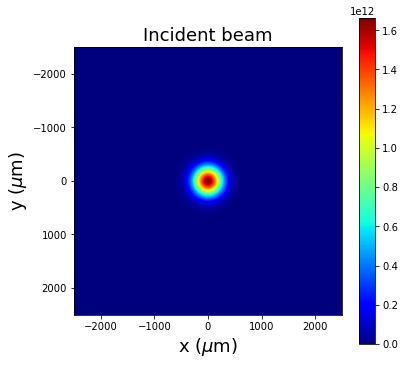

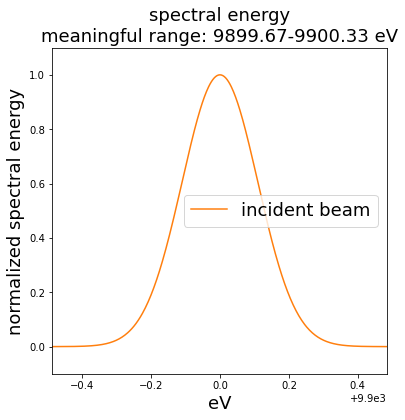

In [6]:
''' transverse intensity profile '''
# spatial profile
fig = plt.figure(figsize=(6,6))
ax1 = fig.add_subplot(111)

if min([npointsx, npointsy])>=4:
    plot_spatial_from_wf(mwf,'incident')
    ax1.set_aspect('equal')
    plt.title('Incident beam', fontsize=18)
else:
    plot_lineout_from_wf(mwf, 'C1',label='incident beam', if_log=0)
    plt.title('Beam intensity lineout')
    
print('done')
plt.savefig(dirname_input+'profile_{}.png'.format(name0),transparent=True)

''' spectrum '''
plt.figure(figsize=(6,6))
aw, evI, intIs = get_spectra(mwf)
eRange = evI.max()-evI.min()
eMin = evI[aw.min()]-eRange/20
eMax = evI.max()-(eMin-evI.min())

plot_spectra(aw, evI, intIs,'C1', label='incident beam')
plt.xlim([eMin, eMax])
plt.savefig(dirname_input+'spectrum_{}.png'.format(name0), transparent=True)

eStart = mwf._srwl_wf.mesh.eStart
eFin = mwf._srwl_wf.mesh.eFin


# Define beamline optics

In [7]:
from WPG_Optics import *
''' beamline crystals '''
ang_as0 = 0                 # asymmetry angle of the first crystal
ang_as1 = -ang_as           # """""""""""""""""""""" second crystal
ang_as2 = ang_as            # """""""""""""""""""""" third crystal
ang_as3 = 0                 # """""""""""""""""""""" 4th crystal

C1_VCC = SRWLOptCryst(d_sp,psi0r,psi0i,psi_hr,psi_hi,psi_hbr,psi_hbi,tc,ang_as0,_uc=uc)
C2_VCC = SRWLOptCryst(d_sp,psi0r,psi0i,psi_hr,psi_hi,psi_hbr,psi_hbi,tc,ang_as1,_uc=uc)
C3_VCC = SRWLOptCryst(d_sp,psi0r,psi0i,psi_hr,psi_hi,psi_hbr,psi_hbi,tc,ang_as2,_uc=uc)
C4_VCC = SRWLOptCryst(d_sp,psi0r,psi0i,psi_hr,psi_hi,psi_hbr,psi_hbi,tc,ang_as3,_uc=uc)

C1_CC = SRWLOptCryst(d_sp,psi0r,psi0i,psi_hr,psi_hi,psi_hbr,psi_hbi,tc,0,_uc=uc)
C2_CC = SRWLOptCryst(d_sp,psi0r,psi0i,psi_hr,psi_hi,psi_hbr,psi_hbi,tc,0,_uc=uc)
C3_CC = SRWLOptCryst(d_sp,psi0r,psi0i,psi_hr,psi_hi,psi_hbr,psi_hbi,tc,0,_uc=uc)
C4_CC = SRWLOptCryst(d_sp,psi0r,psi0i,psi_hr,psi_hi,psi_hbr,psi_hbi,tc,0,_uc=uc)

''' crystal orientation '''
set_crystal_orient(C1_VCC, ekev*1e3, ang_dif_pl, flip=0)
set_crystal_orient(C2_VCC, ekev*1e3, ang_dif_pl, flip=1)
set_crystal_orient(C3_VCC, ekev*1e3, ang_dif_pl, flip=1)
set_crystal_orient(C4_VCC, ekev*1e3, ang_dif_pl, flip=0)

set_crystal_orient(C1_CC, ekev*1e3, ang_dif_pl, flip=1)
set_crystal_orient(C2_CC, ekev*1e3, ang_dif_pl, flip=0)
set_crystal_orient(C3_CC, ekev*1e3, ang_dif_pl, flip=0)
set_crystal_orient(C4_CC, ekev*1e3, ang_dif_pl, flip=1)


### Define beamline

In [8]:
''' drift between OE '''
# VCC branch
z_In_C1_VCC = 0.12
z_C1_C2_VCC = 0.02
z_C2_C3_VCC = 0.2
z_C3_C4_VCC = 0.02
z_C4_Im_VCC = z_In_C1_VCC

D_In_VCC = SRWLOptD(z_In_C1_VCC)    # CC crystal 1 to VCC crystal 1 offset
D_C1_VCC = SRWLOptD(z_C1_C2_VCC)    # C1 - C2
D_C2_VCC = SRWLOptD(z_C2_C3_VCC)    # C2 - C3
D_C3_VCC = SRWLOptD(z_C3_C4_VCC)    # C3 - C4
D_C4_VCC = SRWLOptD(z_C4_Im_VCC)    # VCC crystal 4 to CC crystal 4 offset

# CC branch
z_C1_C2_CC = 0.02
z_C2_C3_CC = z_C2_C3_VCC + z_In_C1_VCC*2
z_C3_C4_CC = 0.02

D_C1_CC = SRWLOptD(z_C1_C2_CC)    # C1 - C2
D_C2_CC = SRWLOptD(z_C2_C3_CC)    # C2 - C3
D_C3_CC = SRWLOptD(z_C3_C4_CC)    # C3 - C4

''' propagation parameters '''
#Wavefront Propagation Parameters:
#[0]:  Auto-Resize (1) or not (0) Before propagation
#[1]:  Auto-Resize (1) or not (0) After propagation
#[2]:  Relative Precision for propagation with Auto-Resizing (1. is nominal)
#[3]:  Allow (1) or not (0) for semi-analytical treatment of quadratic phase terms at propagation
#[4]:  Do any Resizing on Fourier side, using FFT, (1) or not (0)
#[5]:  Horizontal Range modification factor at Resizing (1. means no modification)
#[6]:  Horizontal Resolution modification factor at Resizing
#[7]:  Vertical Range modification factor at Resizing
#[8]:  Vertical Resolution modification factor at Resizing
#[9]:  Type of wavefront Shift before Resizing (not yet implemented)
#[10]: New Horizontal wavefront Center position after Shift (not yet implemented)
#[11]: New Vertical wavefront Center position after Shift (not yet implemented)
#                [ 0] [1] [2]  [3] [4] [5]  [6]  [7]  [8]  [9] [10] [11]
ppD_In_VCC =     [ 0,  0, 1.0,  1,  0, 1.0, 1.0, 1.0, 1.0,  0,  0,   0]
ppC1_VCC =       [ 0,  0, 1.0,  1,  0, 1.0, 1.0, 1.0, 1.0,  0,  0,   0]
ppD_C1_VCC =     [ 0,  0, 1.0,  1,  0, 1.0, 1.0, 1.0, 1.0,  0,  0,   0]
ppC2_VCC =       [ 0,  0, 1.0,  1,  0, 1.0, 1.0, 1.0, 1.0,  0,  0,   0]
ppD_C2_VCC =     [ 0,  0, 1.0,  1,  0, 1.0, 1.0, 1.0, 1.0,  0,  0,   0]

ppC3_VCC =       [ 0,  0, 1.0,  1,  0, 1.0, 1.0, 1.0, 1.0,  0,  0,   0]
ppD_C3_VCC =     [ 0,  0, 1.0,  1,  0, 1.0, 1.0, 1.0, 1.0,  0,  0,   0]
ppC4_VCC =       [ 0,  0, 1.0,  1,  0, 1.0, 1.0, 1.0, 1.0,  0,  0,   0]
ppD_C4_VCC =     [ 0,  0, 1.0,  1,  0, 1.0, 1.0, 1.0, 1.0,  0,  0,   0]

ppC1_CC =        [ 0,  0, 1.0,  1,  0, 1.0, 1.0, 1.0, 1.0,  0,  0,   0]
ppD_C1_CC =      [ 0,  0, 1.0,  1,  0, 1.0, 1.0, 1.0, 1.0,  0,  0,   0]
ppC2_CC =        [ 0,  0, 1.0,  1,  0, 1.0, 1.0, 1.0, 1.0,  0,  0,   0]
ppD_C2_CC =      [ 0,  0, 1.0,  1,  0, 1.0, 1.0, 1.0, 1.0,  0,  0,   0]

ppC3_CC =        [ 0,  0, 1.0,  1,  0, 1.0, 1.0, 1.0, 1.0,  0,  0,   0]
ppD_C3_CC =      [ 0,  0, 1.0,  1,  0, 1.0, 1.0, 1.0, 1.0,  0,  0,   0]
ppC4_CC =        [ 0,  0, 1.0,  1,  0, 1.0, 1.0, 1.0, 1.0,  0,  0,   0]
ppD_C4_CC =      [ 0,  0, 1.0,  1,  0, 1.0, 1.0, 1.0, 1.0,  0,  0,   0]

''' beamlines '''
# branch 1 (VCC)
name1_VCC = 'VCC_2.mono'
BL_VCC = SRWLOptC([D_In_VCC, C1_VCC, D_C1_VCC, C2_VCC, D_C2_VCC, C3_VCC, D_C3_VCC, C4_VCC, D_C4_VCC],
               [ppD_In_VCC, ppC1_VCC, ppD_C1_VCC, ppC2_VCC, ppD_C2_VCC, ppC3_VCC, ppD_C3_VCC, ppC4_VCC, ppD_C4_VCC])

# branch 2 (CC)
name1_CC = 'CC_2.mono'
BL_CC = SRWLOptC([C1_CC, D_C1_CC, C2_CC, D_C2_CC, C3_CC, D_C3_CC, C4_CC],
               [ppC1_CC, ppD_C1_CC, ppC2_CC, ppD_C2_CC, ppC3_CC, ppD_C3_CC, ppC4_CC])

print('done')

done


In [9]:
''' propagation '''
# branch 1 (VCC)
startTime = time.time(); tstamp = time.time()
print('\n\n*** through VCC, t = {}s'.format(round(time.time()-startTime,2)))
fname_VCC1 = dirname_mono + 'wf_{}.h5'.format(name1_VCC)
mwf_VCC1 = propagate_wavefront(fname_incident, BL_VCC, fname_VCC1)
print('propagation lasted: {} min'.format(round((time.time() - startTime) / 6.) / 10.))

# branch 2 (CC)
startTime = time.time(); tstamp = time.time()
print('\n\n*** through CC, t = {}s'.format(round(time.time()-startTime,2)))
fname_CC1 = dirname_mono + 'wf_{}.h5'.format(name1_CC)
mwf_CC1 = propagate_wavefront(fname_incident, BL_CC, fname_CC1)
print('propagation lasted: {} min'.format(round((time.time() - startTime) / 6.) / 10.))




*** through VCC, t = 0.0s
Optical Element: Drift Space
Prop. parameters = [0, 0, 1.0, 1, 0, 1.0, 1.0, 1.0, 1.0, 0, 0, 0]
	L = 0.12
	treat = 0
	
Optical Element: Ideal Crystal
Prop. parameters = [0, 0, 1.0, 1, 0, 1.0, 1.0, 1.0, 1.0, 0, 0, 0]
	angAs = 0
	aux_ang_dif_pl = 1.5707963267948966
	aux_energy = 9900.0
	dSp = 1.9201374688016222
	nvx = -0.945325343551752
	nvy = 5.788448280667626e-17
	nvz = -0.32612880099549946
	psi0i = 1.554410972e-07
	psi0r = -9.964087683e-06
	psiHbi = 1.502594247e-07
	psiHbr = -6.054689535e-06
	psiHi = 1.502594247e-07
	psiHr = -6.054689535e-06
	tc = 0.00015
	tvx = -0.32612880099549946
	tvy = 1.9969629612445126e-17
	uc = 1
	
Optical Element: Drift Space
Prop. parameters = [0, 0, 1.0, 1, 0, 1.0, 1.0, 1.0, 1.0, 0, 0, 0]
	L = 0.02
	treat = 0
	
Optical Element: Ideal Crystal
Prop. parameters = [0, 0, 1.0, 1, 0, 1.0, 1.0, 1.0, 1.0, 0, 0, 0]
	angAs = -0.03490658503988659
	aux_ang_dif_pl = 4.71238898038469
	aux_energy = 9900.0
	dSp = 1.9201374688016222
	nvx = 0.933368

In [10]:
# check dimensions
print('input',np.asarray(mwf.get_limits())*1e6)
print('VCC',np.asarray(mwf_VCC1.get_limits())*1e6)
print('CC',np.asarray(mwf_CC1.get_limits())*1e6)

R-space
input [-2500.  2500.  2500. -2500.]
R-space
VCC [-2510.17673867  2490.5659829   2490.56598343 -2510.1767392 ]
R-space
CC [-2510.19080509  2490.57993942  2490.57966141 -2510.19052488]


# Plots

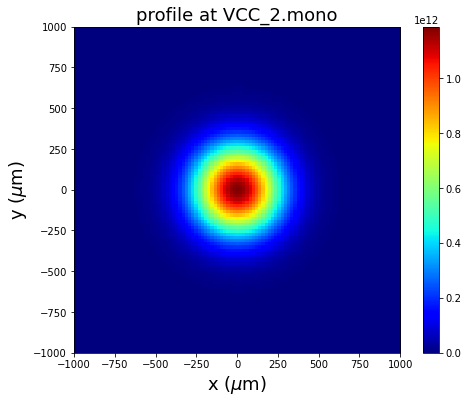

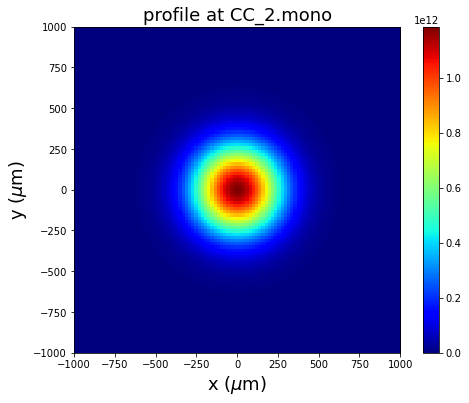

In [11]:
''' profile '''
if_log = 0
fov = 2000
fig = plt.figure(figsize=(8,6))
ax1 = fig.add_subplot(111)
plot_spatial_from_wf(mwf_VCC1, label=name1_VCC, if_log=if_log)
plt.xlim([-fov/2,fov/2]); plt.ylim([-fov/2,fov/2])
ax1.set_aspect('equal')
plt.savefig(dirname_mono+'profile_{}.png'.format(name1_VCC),transparent=True)

fig = plt.figure(figsize=(8,6))
ax1 = fig.add_subplot(111)
plot_spatial_from_wf(mwf_CC1, label=name1_CC, if_log=if_log)
plt.xlim([-fov/2,fov/2]); plt.ylim([-fov/2,fov/2])
ax1.set_aspect('equal')
plt.savefig(dirname_mono+'profile_{}.png'.format(name1_CC),transparent=True)


R-space
R-space
R-space
R-space
R-space
R-space
R-space
R-space
R-space
R-space


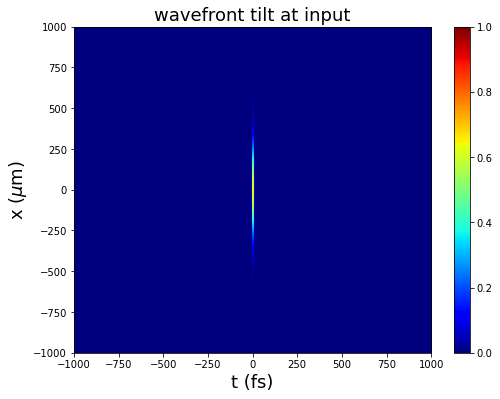

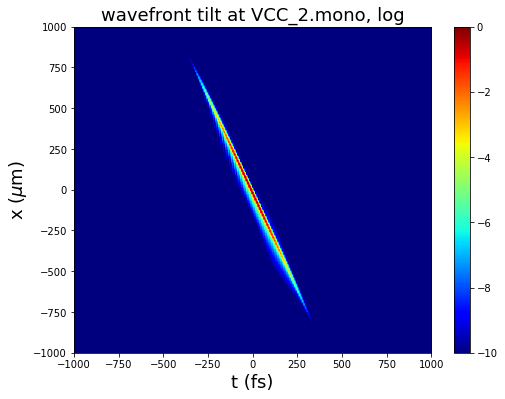

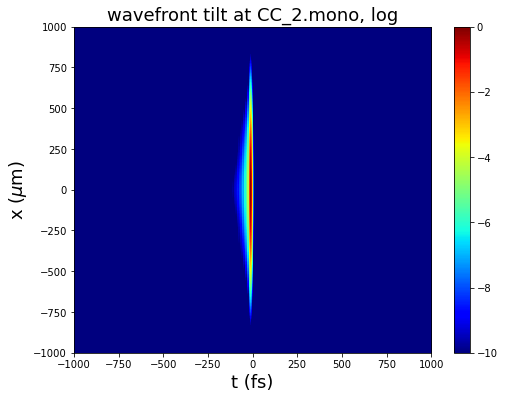

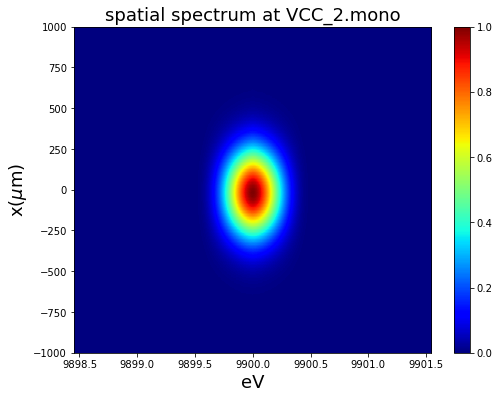

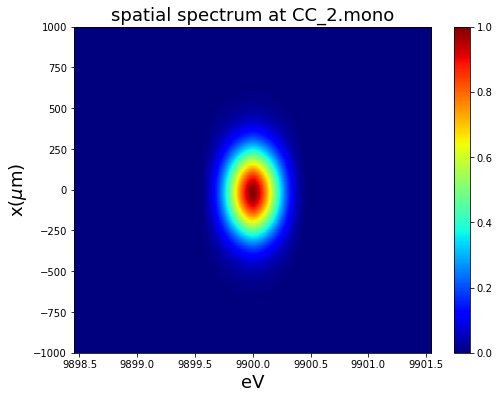

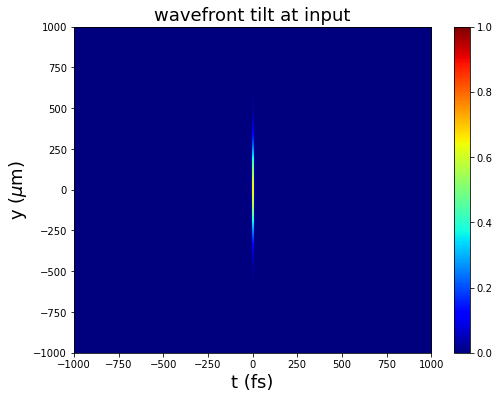

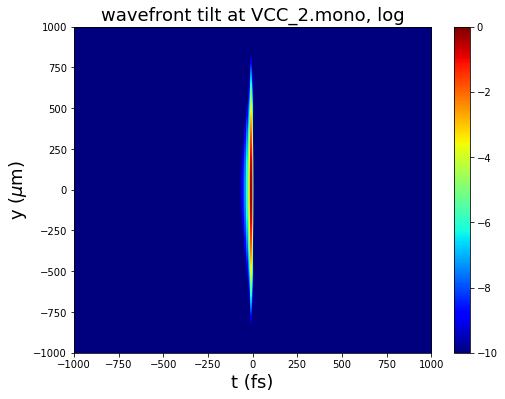

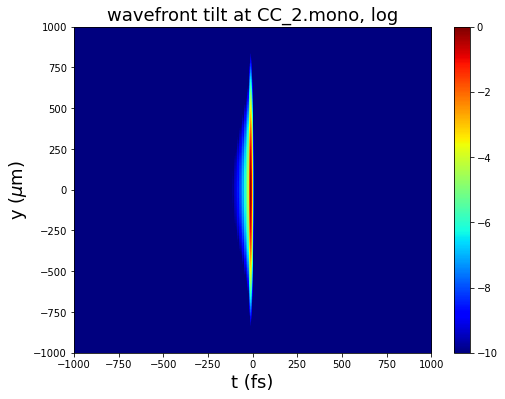

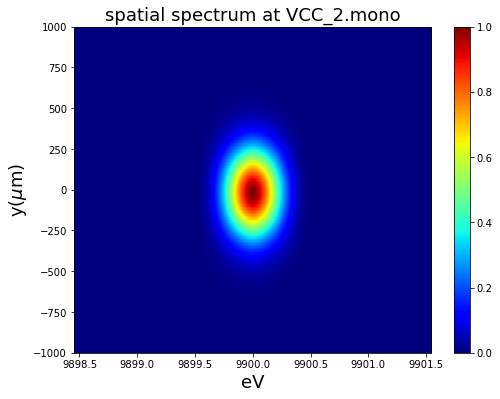

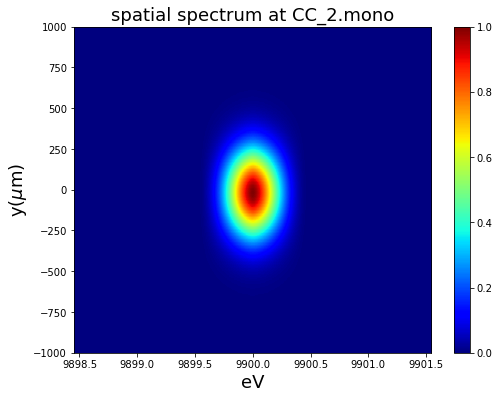

In [12]:
''' tilt and spectrum '''
if_log = 1
fov_y = 2000      # um
fov_t = trange*1e15    # fs

for dim in ['x','y']:
    if dim == 'y': ori = 'V'
    else: ori = 'H'

    plt.figure(figsize=(8,6))
    plot_tilt_from_wf(mwf,label=name0,if_log=0, ori=ori)
    plt.xlim([-fov_t/2,fov_t/2]); plt.ylim([-fov_y/2,fov_y/2])
    plt.savefig(dirname_input+'tilt_{}_{}.png'.format(dim,name0),transparent=True)

    plt.figure(figsize=(8,6))
    plot_tilt_from_wf(mwf_VCC1,label=name1_VCC,if_log=if_log, ori=ori)
    plt.xlim([-fov_t/2,fov_t/2]); plt.ylim([-fov_y/2,fov_y/2])
    plt.savefig(dirname_mono+'tilt_{}_{}.png'.format(dim,name1_VCC),transparent=True)

    plt.figure(figsize=(8,6))
    plot_tilt_from_wf(mwf_CC1,label=name1_CC,if_log=if_log, ori=ori)
    plt.xlim([-fov_t/2,fov_t/2]); plt.ylim([-fov_y/2,fov_y/2])
    plt.savefig(dirname_mono+'tilt_{}_{}.png'.format(dim,name1_CC),transparent=True)
    
    plt.figure(figsize=(8,6))
    plot_tilt_freq_from_wf(mwf_VCC1,label=name1_VCC,if_log=0, ori=ori)
    plt.xlim([eStart, eFin]); plt.ylim([-fov_y/2,fov_y/2])
    plt.savefig(dirname_mono+'spectrum_{}_{}.png'.format(dim,name1_VCC),transparent=True)
    
    plt.figure(figsize=(8,6))
    plot_tilt_freq_from_wf(mwf_CC1,label=name1_CC,if_log=0, ori=ori)
    plt.xlim([eStart, eFin]); plt.ylim([-fov_y/2,fov_y/2])
    plt.savefig(dirname_mono+'spectrum_{}_{}.png'.format(dim,name1_CC),transparent=True)


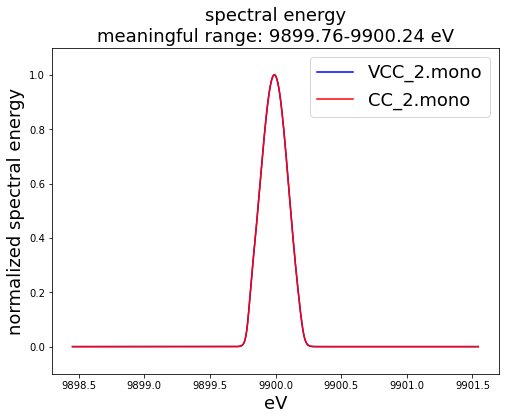

In [13]:
''' spectrum '''
aw_VCC, axis_VCC, int_VCC = get_spectra(mwf_VCC1)
aw_CC, axis_CC, int_CC = get_spectra(mwf_CC1)

plt.figure(figsize=(8,6))
plot_spectra(aw_VCC, axis_VCC, int_VCC, 'b', label=name1_VCC)
plot_spectra(aw_VCC, axis_VCC, int_VCC, 'r', label=name1_CC)

plt.savefig(dirname_mono+'spectrum_all.png',transparent=True)


### Compress save

In [14]:
fname_incident = dirname_input+'{}_compressed.h5'.format(name0)

''' incident '''
for filename in os.listdir(dirname_input):
    if filename.endswith('.h5'):
        if not filename.endswith('compressed.h5'):
            os.remove(dirname_input+filename)
compress_save(mwf, fname_incident)


R-space


In [15]:
import winsound
winsound.PlaySound("*", winsound.SND_ALIAS)
winsound.PlaySound("*", winsound.SND_ALIAS)
winsound.PlaySound("*", winsound.SND_ALIAS)